# Problem set 3-Computational Physics.
# Matheus Azevedo Silva Pessôa, ID: 260889844

1. Using Gaussian, uncorrelated errors, what do you get for χ 2 for the model
in my example script, where the Hubble constant H 0 = 65 km/s, the physical
baryon density ω b h 2 =0.02, the cold dark matter density ω c h 2 = 0.1 the optical
depth τ = 0.05, the primordial amplitude of fluctuations is A s = 2 × 10 −9 , and
the slope of the primordial power law is 0.96 (where 1 would be scale-invariant).
The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by h 2 where h ≡ H 0 /100 ∼ 0.7. Note
that the universe is assumed to be spatially flat (for reasons too long to justify
here), so the dark matter density relative to critical for these parameters would
be 1 − (ω b h 2 + ω c h 2 )/h 2 =71.6% for the parameters assumed here. (You may
want to play around plotting different models as you change parameters to get
a sense for how the CMB depends on them.) If everything has gone well, you
should get something around 1588 (please give a few extra digits) for χ 2 for this
model.

This is our plot for the cmb and the model given.

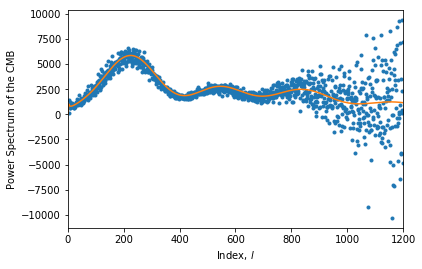

In [277]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt


plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap.txt')

plt.clf();
#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
plt.plot(wmap[:,0],wmap[:,1],'.')

cmb=get_spectrum(pars)
plt.plot(cmb)
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.xlim(0,len(wmap[:,1]))
#We notice the need of extracting the extrapolating points otherwise we won't be able to calculate the chisq.
plt.show()

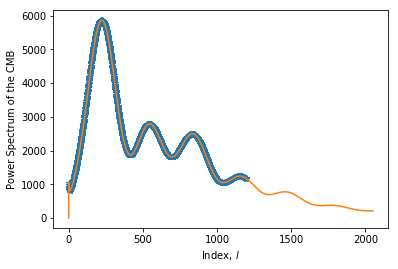

In [278]:
#Cutting the data so everything goes nicely.
cmb2=cmb[2:len(wmap[:,1])+2]
plt.plot(cmb2,'*')
plt.plot(cmb)
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.show()
#Cut successful!

This is the value we find for our chi-squared!

In [3]:
res=cmb2-wmap[:,1]
err=wmap[:,2]
chisq=np.sum((res/err)**2)
print(chisq)

1588.2376458618892


2. Keeping the optical depth fixed at 0.05, write a Newton’s method/Levenberg-
Marquardt minimizer and use it to find the best-fit values for the other param-
eters, and their errors. What are they? If you were to keep the same set of
parameter but now float τ , what would you expect the new errors to be? Note
that CAMB does not provide derivatives with respect to parameters, so you’ll
have to come up with something for that. Please also provide a plot showing
why we should believe your derivative estimates.

In [297]:
#Initializing the function again to refresh the variables.
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap.txt')

#plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*')
#plt.plot(wmap[:,0],wmap[:,1],'.')

cmb=get_spectrum(pars)
#plt.plot(cmb)
#plt.xlabel(r'Index, $l$')
#plt.ylabel('Power Spectrum of the CMB')
#plt.xlim(0,len(wmap[:,1]))
#plt.show()

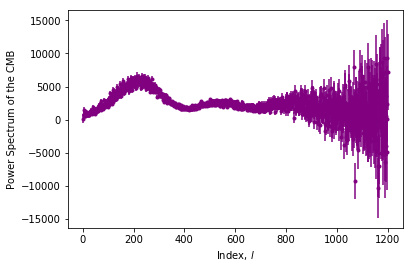

In [293]:
#Curiosity plot on how the error bars look like.
plt.errorbar(wmap[:,0], wmap[:,1], yerr=err, fmt='.', color='purple', barsabove=True)
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.show()

Now we need to create a get_spectrum function that takes into account the whole parameters.

Now we will basically do the same thing but now we'll consider a Taylor expansion to the first order in order to see the behavior of our new fit, using a small value of $\delta$. This is basically the same implementation for a derivative of a function I did in the first assignment however now just taking the first Taylor expansion term. 

What I do here is approximate the derivative of the function as: $f'(x) = \frac{f(x+h)-f(x)}{h}$, and proceed with the usual Newton's Method.



In [6]:
def get_newspectrum(pars,lmax=1199,delta=10E-9):
    tau=0.05
    function = get_spectrum([pars[0],pars[1],pars[2],tau,pars[3],pars[4]], lmax)
    dH0=(get_spectrum([pars[0]+delta,pars[1],pars[2],tau,pars[3],pars[4]],lmax)-function)/delta
    dombh2=(get_spectrum([pars[0],pars[1]+delta,pars[2],tau,pars[3],pars[4]],lmax)-function)/delta
    domch2=(get_spectrum([pars[0],pars[1],pars[2]+delta,tau,pars[3],pars[4]],lmax)-function)/delta
    dAs=(get_spectrum([pars[0],pars[1],pars[2],tau,pars[3]+delta,pars[4]],lmax)-function)/delta
    dns=(get_spectrum([pars[0],pars[1],pars[2],tau,pars[3],pars[4]+delta],lmax)-function)/delta
    
    fun=function[2:]
    
    derivs=np.zeros([lmax,len(pars)])
    derivs[:,0]=dH0[2:]
    derivs[:,1]=dombh2[2:]
    derivs[:,2]=domch2[2:]
    derivs[:,3]=dAs[2:]
    derivs[:,4]=dns[2:]
    
    return fun, derivs

pars=[65,0.02,0.1,2e-9,0.96]

cmb2,derivs=get_newspectrum(pars)
resid = wmap[:,1] - cmb2
chisquared=np.sum((resid/err)**2)
print(chisquared)

for i in range(30):    
    grad = 2*np.dot(derivs.transpose(), resid)
    curve = 2*np.dot(derivs.transpose(), derivs)
    covariance = np.linalg.inv(curve)
    pars = pars + np.dot(covariance, grad)
    
    newcmb, derivs=get_newspectrum(pars)
    resid = wmap[:,1] - newcmb
    chisquared=np.sum((resid/err)**2)
    print(chisquared)

1588.4366651126402
1263.0010724183833
1242.239961868749
1245.1459636460363
1244.2706949823812
1247.104621368635
1246.7572781499093
1245.4723310255831
1245.7398338456183
1243.3076828128978
1258.32666522288
1246.4931925133028
1243.7855704676558
1242.018171409185
1245.241273561109
1246.8040642170433
1243.578643138456
1242.344168915295
1264.6842214383992
1246.1010049451738
1248.3021857753351
1244.2552971210446
1250.8261477165652
1244.4748802906568
1259.5613596687522
1245.8427538708586
1245.4743026902809
1266.315883582039
1249.4241959858787
1252.8570517556745
1245.4032745973204


The value for chi squared diminushed and I consider this as a good result for Newton's Method. It can be possible that for more iterations this gives us larger numbers, and in this case we would need to use Levenberg-Marquadt's method for implementing our solution.

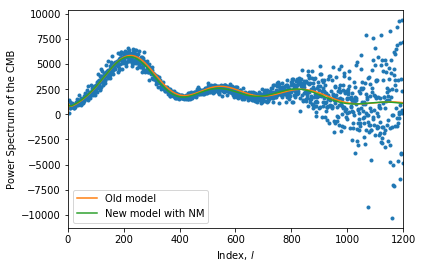

The best-fit parameters encountered are:
H0 = 65.0 +/- 2.1617751116068082e-05
ombh2 = 0.02 +/- 1.3056767103492545e-12
omch2 = 0.1 +/- 1.2134611392247363e-10
As = 0.05 +/- 4.025482627573405e-27
ns = 2e-09 +/- 8.495777364588131e-10


In [302]:
plt.plot(wmap[:,0],wmap[:,1],'.')
plt.plot(cmb,label='Old model')
plt.plot(newcmb,label="New model with NM")
plt.xlim(0,len(wmap[:,1]))
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.legend()
plt.show()
print('The best-fit parameters encountered are:')
print('H0 = '+repr(pars[0])+' +/- '+repr(np.diag(covariance)[0]))
print('ombh2 = '+repr(pars[1])+' +/- '+repr(np.diag(covariance)[1]))
print('omch2 = '+repr(pars[2])+' +/- '+repr(np.diag(covariance)[2]))
print('As = '+repr(pars[3])+' +/- '+repr(np.diag(covariance)[3]))
print('ns = '+repr(pars[4])+' +/- '+repr(np.diag(covariance)[4]))

We note that this new fit also changes the height of the peaks we see in the plot, thus indicating a new interpretation of the CMB in terms of the Universe's components such as the matter/radiation concentration, and giving room for interpretations of the Dark Matter, since usually the presence of bigger peaks in the odd multiples can be considered a proof of the presence of Dark Matter in the Universe as we have seen in class.

"In the context of CMB observations, the optical depth to reionization, τ, is a unitless quantity which provides a measure of the line-of-sight free-electron opacity to CMB radiation. Under the assumption of instantaneous, complete reionization at redshift zreion, τ is computed as the integral of the electron density times the Thomson cross section over the geometrical path length computed between z=0 (i.e., today) and $z_{reion}$ (see e.g. Griffiths et al. 1999, Venkatesan 2000, Shull & Venkatesan 2007). Assuming a fixed dependence of electron density on redshift, a larger value of τ implies a larger value of $z_{reion}$ and thus an earlier onset of star and galaxy formation; τ = 0 implies no reionization at all." Source: https://lambda.gsfc.nasa.gov/education/graphic_history/taureionzation.cfm?fbclid=IwAR2jnSzzsZzZFSeZoxPLbndGwvxLcoj6ZjT-chd9NFbauepYKHiFbxGk6fI
 
We can state that for different values of $\tau$, we would have different opacities regarding the CMB and thus our errors would arise in the interpretation of the Cosmology we are using do describe the Universe and to find the correct Epoch of Reionization (EOR). 


3.  Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ . However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ . What are your parameter limits now? Please also present an argument as to why you think your chains are converged. As a reminder, you can draw samples of correlated data from a covariance matrix with r = np.linalg.cholesky(mat); d =np.dot(r, np.random.randn(r.shape[0])). You will want to use the covariance matrix from part 2) when drawing samples for the MCMC.

The MCMC method I implement here is completely inspired in the example we have seen in the tutorial, which helped me a lot in understanding more about the method itself. We start by defining the function get_step(),which was created to attribute and control the size of the steps in our MCMC method. This is how we will track the behavior of all the 6 variables we're varying. 

In [129]:
#To find these values, I have seen the actual values in the old model and then diminushed some orders of magnitude
# so we can obtain appropriate values for our steps each time. In order to obtain a fully converged chain, we would
# need to refine these values for the starting guesses in order to obtain the 25% acceptance rate.
def get_step():
    step1 = 0.05*np.random.rand()
    step2 = 1e-4*np.random.rand()
    step3 = 1e-3*np.random.rand()
    step4 = 1e-4*np.random.rand()
    step5 = 1e-11*np.random.rand()
    step6 = 1e-3*np.random.rand()
    return [step1, step2, step3, step4, step5, step6]

def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq
#Get_chisq is working just fine! Just to verify
get_chisq(wmap[:,1],cmb2,err)
chisq=get_chisq(wmap[:,1],cmb2,err)
print(chisq)

1588.2376458618892


In [130]:
print(pars) #these are the normal current parameters we have for the plot.

[6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]


In [136]:
get_step() #Now we know the get_step function is working properly.

[0.011529531217020928,
 7.1715914280358e-05,
 0.0005322786818409163,
 4.9547396539118665e-05,
 7.40100281712098e-12,
 0.0001719125817708711]

The MCMC function below will take the number of steps, calculate the chi squared and register which chains we're using. While the number of steps taken is smaller than the number of steps we wish to accomplish with this setup, the algorithm starts, firsts by taking the values of each one of the parameters "pars" we defined before and adding a random number to it, so it takes a random walk. We also need to guarantee valid values for $\tau$, and thus this is why I added an if statement. 

In [172]:
def mcmc (pars):
    nstep = 100
    steps_taken = 0
    chisq=get_chisq(wmap[:,1],cmb2,err)
    chisq_array = np.zeros(nstep)
    chains = np.zeros([nstep, len(pars)])
    
    while steps_taken < nstep:
        # We're updating all our parameters considering 
        #the get_step() function.
        
        new_H0 = pars[0] + get_step()[0]
        new_ombh2 = pars[1] + get_step()[1]
        new_omch2 = pars[2] + get_step()[2]
        new_tau = pars[3] + get_step()[3]
        new_As = pars [4] + get_step()[4]
        new_ns = pars [5] + get_step()[5]
        
        #want to guarantee good values for tau!
        if new_tau <= 0:
            new_tau = pars[3] + get_step(step_size)
            continue
        
        new_pars = [new_H0, new_ombh2, new_omch2, new_tau, new_As, new_ns]
        new_cmb = get_spectrum(new_pars, lmax=1199)
        new_cmb = new_cmb[2:]
        new_chisq = get_chisq(new_cmb, wmap[:,1], err)
                
        delta_chisq = new_chisq - chisq
        
        prob_step = np.exp(-0.5*delta_chisq)
        
        accept = np.random.rand(1) <prob_step
        
        chisq_array[steps_taken]  = chisq
        chains[steps_taken,:] = new_pars
        steps_taken += 1
        #print(steps_taken)
        
        if accept:
            pars = new_pars
            chisq = new_chisq
            #print('Accepted! LOL')
    return chains, chisq_array

In [173]:
chains, chisqs = mcmc(pars)

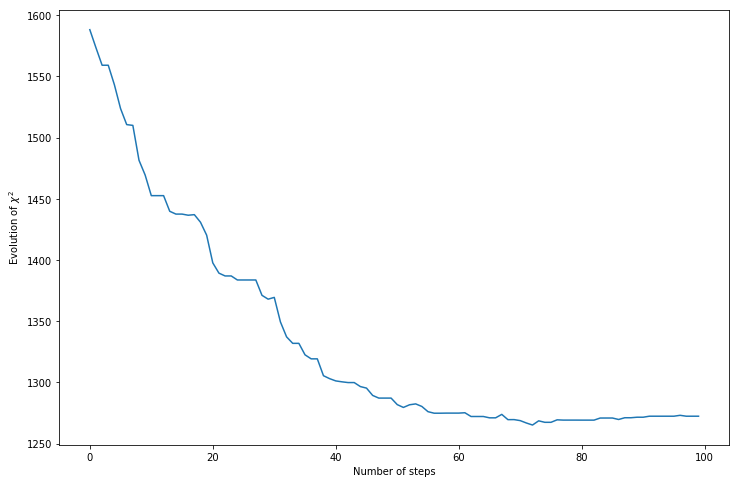

In [285]:
# Let's see how our chisq varied
plt.figure(figsize=(12,8))
plt.plot(chisqs)
plt.xlabel(r'Number of steps')
plt.ylabel(r'Evolution of $\chi^2$')
plt.show()

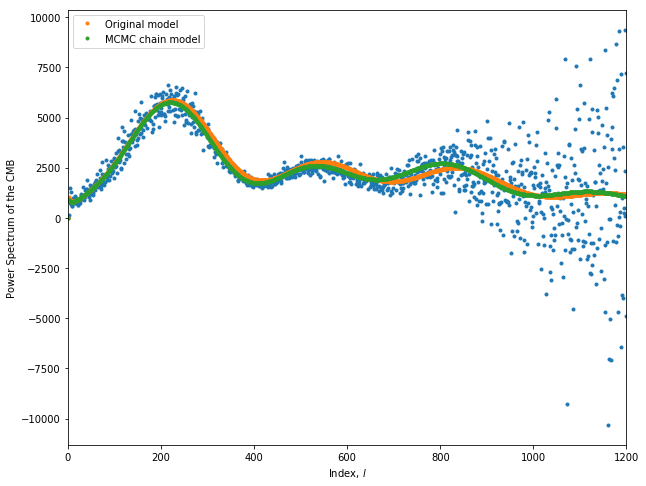

In [286]:
plt.figure(figsize=(10,8))
plt.plot(wmap[:,0],wmap[:,1],'.')
plt.plot(cmb,'.',label="Original model")
plt.plot(get_spectrum(chains[nstep-1]),'.',label="MCMC chain model")
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.xlim(0,len(wmap[:,1]))
plt.legend()
plt.show()

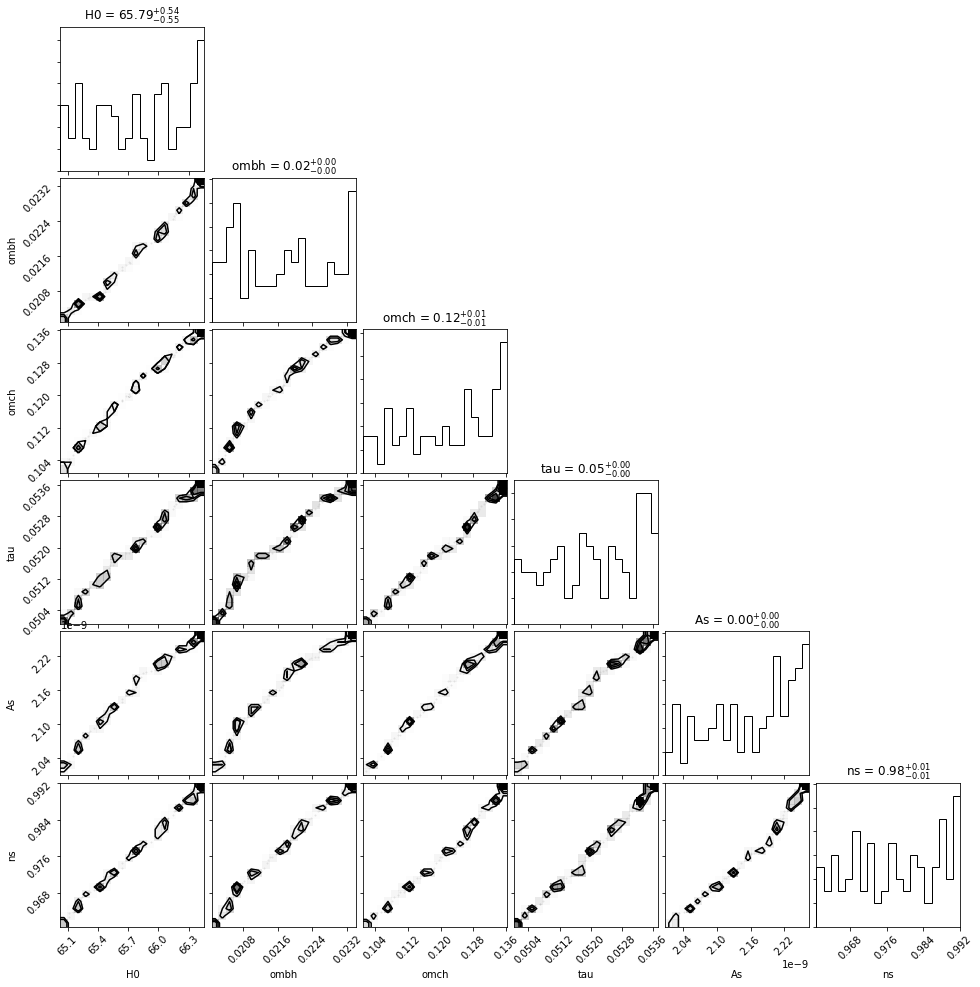

In [242]:
chains = np.array(chains)
corner.corner(chains,labels=["H0","ombh","omch","tau","As","ns"],show_titles=True,title_fmt='.2f')
plt.show()

These are the results we get. For an ideally fully converged chain, we would need to increase step numbers and get an optimal number for the order of magnitude we add in each step. Ideally, these circles would be concentrated in one spot, indicating that the change is not so big starting at that specific point, for each of the parameters we're varying. 

4. The Planck satellite has independently measured the CMB sky, and finds
that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in
as a prior on the value of τ . What are your new parameter values/constraints?
You can also take your chain from part 3) and importance sample it (weighting
by the prior) with the Planck τ prior. How to those results compare to the full
chain results?

The first interpretation I give to this is that we can fix the value for the optical depth first and see how the rest of the chain evolves without significant changes in $\tau$. The code that follows is a first attempt to this, and then I also make another plot showing the behavior for the case where we start at a different value for $\tau$, now $\tau=0.0544$ instead of not taking it into account at all.

In [205]:
def get_step():
    step1 = 0.05*np.random.rand()
    step2 = 1e-4*np.random.rand()
    step3 = 0
    step4 = 1e-4*np.random.rand()
    step5 = 1e-11*np.random.rand()
    step6 = 1e-3*np.random.rand()
    return [step1, step2, step3, step4, step5, step6]

def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq
#Get_chisq is working just fine!
get_chisq(wmap[:,1],cmb2,err)
chisq=get_chisq(wmap[:,1],cmb2,err)
print(chisq)

pars[3] = 0.0544

1588.2376458618892


In [206]:
def mcmc_tau (pars):
    nstep = 100
    steps_taken = 0
    chisq=get_chisq(wmap[:,1],cmb2,err)
    chisq_array = np.zeros(nstep)
    chains = np.zeros([nstep, len(pars)])
    
    while steps_taken < nstep:
        # We're updating all our parameters considering 
        #the get_step() function.
        
        new_H0 = pars[0] + get_step()[0]
        new_ombh2 = pars[1] + get_step()[1]
        new_omch2 = pars[2] + get_step()[2]
        new_tau = pars[3] + get_step()[3]
        new_As = pars [4] + get_step()[4]
        new_ns = pars [5] + get_step()[5]
        
        #want to guarantee good values for tau!
        if new_tau <= 0:
            new_tau = pars[3] + get_step(step_size)
            continue
        
        new_pars = [new_H0, new_ombh2, new_omch2, new_tau, new_As, new_ns]
        new_cmb = get_spectrum(new_pars, lmax=1199)
        new_cmb = new_cmb[2:]
        new_chisq = get_chisq(new_cmb, wmap[:,1], err)
                
        delta_chisq = new_chisq - chisq
        
        prob_step = np.exp(-0.5*delta_chisq)
        
        accept = np.random.rand(1) <prob_step
        
        chisq_array[steps_taken]  = chisq
        chains[steps_taken,:] = new_pars
        steps_taken += 1
        #print(steps_taken)
        
        if accept:
            pars = new_pars
            chisq = new_chisq
            #print('Accepted! LOL')
    return chains, chisq_array

In [207]:
chains2, chisqs2 = mcmc_tau(pars)

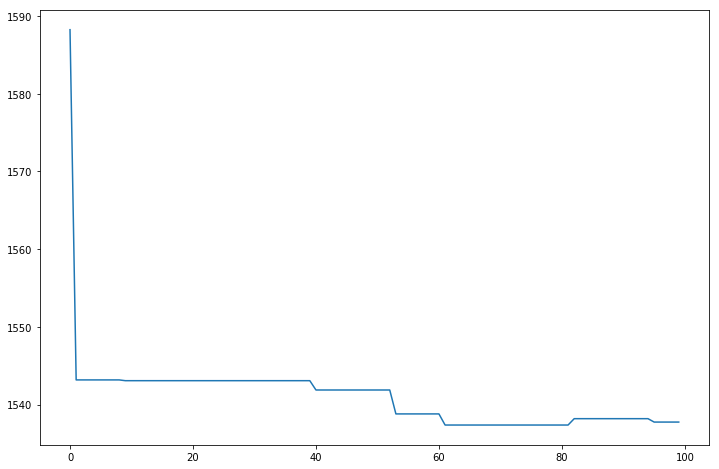

In [208]:
# Let's see how our chisq varied
plt.figure(figsize=(12,8))
plt.plot(chisqs2)
plt.show()

In [253]:
H0 = chains2[:,0]
ombh = chains2[:,1]
omch = chains2[:,3]
As = chains2[:,4]
ns = chains2[:,5]

new_chain = H0,ombh,omch,As,ns
new_chain=np.transpose(new_chain)

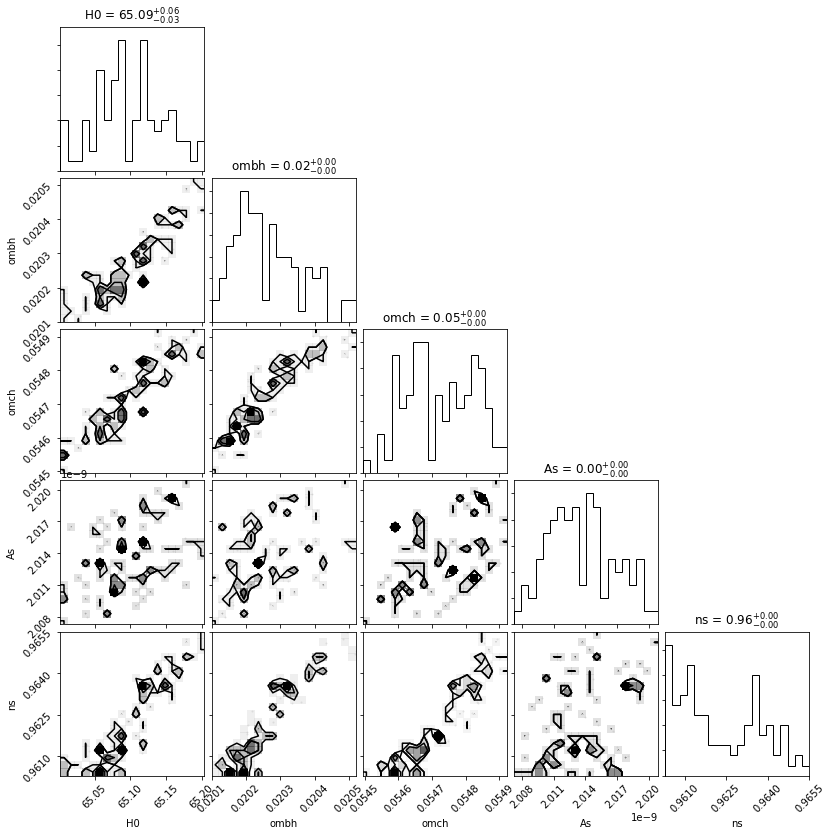

In [254]:
#new_chain = np.array(chains)
corner.corner(new_chain,labels=["H0","ombh","omch","As","ns"],show_titles=True,title_fmt='.2f')
plt.show()

Comparing these results to the complete chain, we notice a non-uniformity in the distribution of the parameters although we see a smaller change in the values for chi-squared as the chain moved to the last step values in comparison to the other case.  

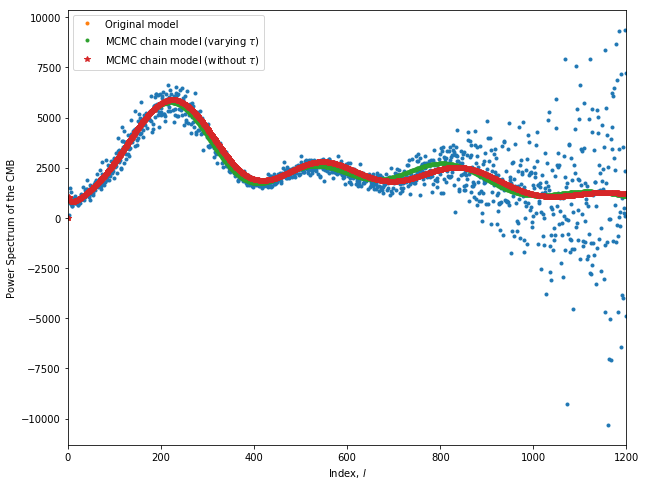

In [287]:
plt.figure(figsize=(10,8))
plt.plot(wmap[:,0],wmap[:,1],'.')
plt.plot(cmb,'.',label="Original model")
plt.plot(get_spectrum(chains[nstep-1]),'.',label=r'MCMC chain model (varying $\tau$)')
plt.plot(get_spectrum(chains2[nstep-1]),'*',label=r'MCMC chain model (without $\tau$)')
plt.xlim(0,len(wmap[:,1]))
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.legend()
plt.show()

Now this is my second try to respond properly, now starting with $\tau=0.0544$ instead of not updating it at all during our steps.

In [305]:
def get_step():
    step1 = 0.05*np.random.rand()
    step2 = 1e-4*np.random.rand()
    step3 = 1e-3*np.random.rand()
    step4 = 1e-4*np.random.rand()
    step5 = 1e-11*np.random.rand()
    step6 = 1e-3*np.random.rand()
    return [step1, step2, step3, step4, step5, step6]

def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq
#Get_chisq is working just fine!
get_chisq(wmap[:,1],cmb2,err)
chisq=get_chisq(wmap[:,1],cmb2,err)
print(chisq)
pars[3] = 0.0544

1588.2376458618892


In [307]:
def mcmc_new (pars):
    nstep = 100
    steps_taken = 0
    chisq=get_chisq(wmap[:,1],cmb2,err)
    chisq_array = np.zeros(nstep)
    chains = np.zeros([nstep, len(pars)])
    
    while steps_taken < nstep:
        # We're updating all our parameters considering 
        #the get_step() function.
        
        new_H0 = pars[0] + get_step()[0]
        new_ombh2 = pars[1] + get_step()[1]
        new_omch2 = pars[2] + get_step()[2]
        new_tau = pars[3] + get_step()[3]
        new_As = pars [4] + get_step()[4]
        new_ns = pars [5] + get_step()[5]
        
        #want to guarantee good values for tau!
        if new_tau <= 0:
            new_tau = pars[3] + get_step(step_size)
            continue
        
        new_pars = [new_H0, new_ombh2, new_omch2, new_tau, new_As, new_ns]
        new_cmb = get_spectrum(new_pars, lmax=1199)
        new_cmb = new_cmb[2:]
        new_chisq = get_chisq(new_cmb, wmap[:,1], err)
                
        delta_chisq = new_chisq - chisq
        
        prob_step = np.exp(-0.5*delta_chisq)
        
        accept = np.random.rand(1) <prob_step
        
        chisq_array[steps_taken]  = chisq
        chains[steps_taken,:] = new_pars
        steps_taken += 1
        #print(steps_taken)
        
        if accept:
            pars = new_pars
            chisq = new_chisq
            #print('Accepted! LOL')
    return chains, chisq_array

In [308]:
chains3, chisqs3 = mcmc_new(pars)

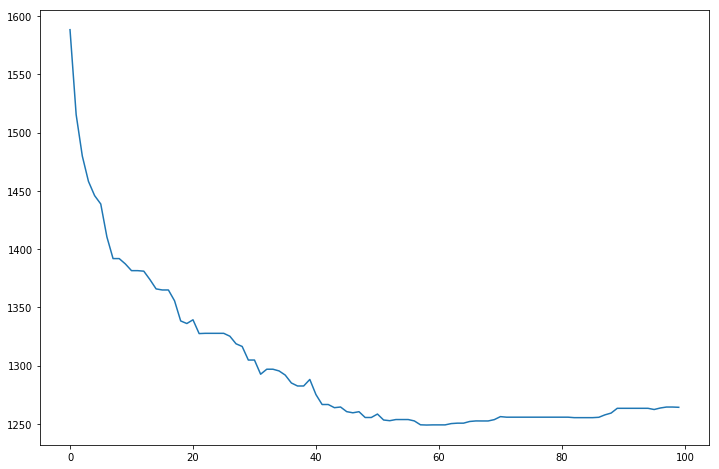

In [309]:
# Let's see how our chisq varied
plt.figure(figsize=(12,8))
plt.plot(chisqs3)
plt.show()

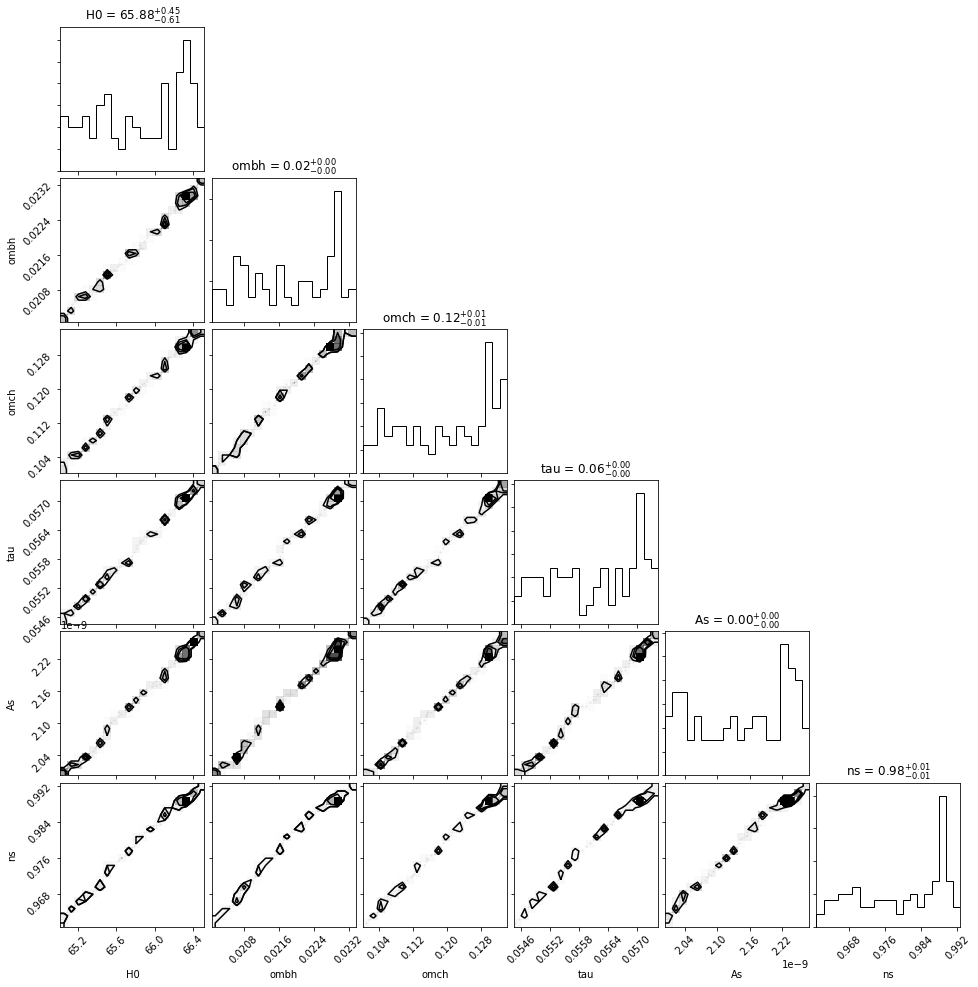

In [310]:
chains3 = np.array(chains3)
corner.corner(chains3,labels=["H0","ombh","omch","tau","As","ns"],show_titles=True,title_fmt='.2f')
plt.show()

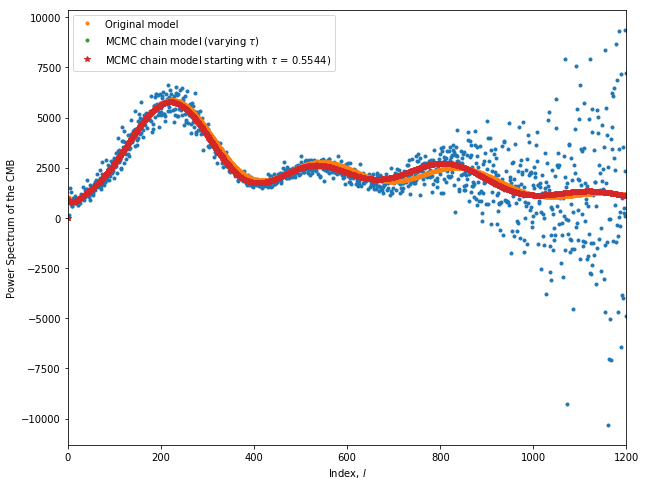

In [312]:
plt.figure(figsize=(10,8))
plt.plot(wmap[:,0],wmap[:,1],'.')
plt.plot(cmb,'.',label="Original model")
plt.plot(get_spectrum(chains[nstep-1]),'.',label=r'MCMC chain model (varying $\tau$)')
plt.plot(get_spectrum(chains3[nstep-1]),'*',label=r'MCMC chain model starting with $\tau$ = 0.5544)')
plt.xlim(0,len(wmap[:,1]))
plt.xlabel(r'Index, $l$')
plt.ylabel('Power Spectrum of the CMB')
plt.legend()
plt.show()

Okay, we did not get much information out of this, since the $\tau$ value being added makes the whole chain to have a more uniform behavior too. CONCLUSION: we would need both to increase the number of steps in our function and provide initial better guesses if we want the function to converge at the 25% rate we are expecting the MCMC method to produce.